In [1]:
import sys
sys.path.insert(1, './env')
sys.path.insert(1, './agents')

import gym
import pylab
import random
import aa_gun
import strategy_imitation, sarsa
import numpy as np
from collections import deque
import keras
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt

from tensorflow.keras.applications import mobilenet_v2,resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

EPISODES = 30000
#pip install git+git://github.com/jaredwinick/img2vec-keras.git

Using TensorFlow backend.
/home/sd/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sd/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sd/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sd/anaconda3/lib/python3.7/site-packages/tensorflow/python/fra

In [15]:
_IMAGE_NET_TARGET_SIZE = (224, 224)
_EMBEDDING_SIZE = 1280

class Img2Vec(object):
    def __init__(self):
        model = mobilenet_v2.MobileNetV2(weights='imagenet')
        if 0:
            for layer in model.layers:
                print(layer.name)
        layer_name = model.layers[-2].name
        self.intermediate_layer_model = Model(inputs=model.input, 
                                              outputs=model.get_layer(layer_name).output)

    def get_vec(self, image_source, is_file=False,resize_type='crop'):
        """ Gets a vector embedding from an image.
        :param image_path: path to image on filesystem
        :returns: numpy ndarray
        """
        if is_file:
            img = image.load_img(image_source, target_size=_IMAGE_NET_TARGET_SIZE)
            x = image.img_to_array(img)
        else:
            #is array. image.array_to_img(state) to show
            if resize_type=='resize':
                img = image.array_to_img(image_source) 
                img=img.resize(_IMAGE_NET_TARGET_SIZE)
                x = image.img_to_array(img)
            elif resize_type=='crop':
                x=np.zeros([_IMAGE_NET_TARGET_SIZE[0],_IMAGE_NET_TARGET_SIZE[1],3])
                x[:image_source.shape[0],:image_source.shape[1],:]=image_source
        x = np.expand_dims(x, axis=0)
        x = mobilenet_v2.preprocess_input(x)
        intermediate_output = self.intermediate_layer_model.predict(x)
        return intermediate_output[0]

In [ ]:
# In case of CartPole-v1, maximum length of episode is 500
#env = aa_gun.AA_gun_simple0_env()
env = gym.make('Seaquest-v0')

#env=CartPoleEnv9()
# get size of state and action from environment
state_size = _EMBEDDING_SIZE #размер эмбеддинга
action_size = env.action_space.n

#agent = DoubleDQNAgent(state_size, action_size)
agent = sarsa.SarsaAgent(state_size, action_size,layers_size=[50,200])
agent.train_start=3000
#agent = strategy_imitation.ImitAgent(state_size, action_size)
agent.render=True

scores, episodes = [], []
reward_lst = []
s_list=[]
a_list=[]

i2v=Img2Vec()

for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset()

    while not done:
        if (e in range(100,300)) or (e in range(300,306)) or (e in range(400,406)) or (e in range(500,506)) or (e in range(600,604)):
            if agent.render:
                env.render()

        # get action for the current state and go one step in environment
        if state.shape!=(1,_EMBEDDING_SIZE):
            state=i2v.get_vec(state)
        state = np.reshape(state, [1, state_size])
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        
        next_state=i2v.get_vec(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        # if an action make the episode end, then gives penalty of -100
        

        # save the sample <s, a, r, s'> to the replay memory
        reward_curr=reward
        #if done:
        #    reward_curr -= 100
        agent.append_sample(state, action, reward_curr, next_state, done)
        #if next_state[0,11]!=reward:
        #    print('state[13]!=reward',state[0,11],reward)
        #
        s_list.append(state)
        a_list.append(action)
        reward_lst.append(reward)
        #
        
        # every time step do the training
        agent.train_model()
        score += reward
        state = next_state

        if done:
            # every episode update the target model to be same with model
            agent.update_target_model()

            # every episode, plot the play time
            scores.append(score)
            episodes.append(e)
            pylab.plot(episodes, scores, 'b')
            #pylab.savefig("./save_graph/aa_gun_dqn.png")
            print("episode:", e, "  score:", score,np.mean(scores), "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon)

            # if the mean of scores of last 10 episode is bigger than 490
            # stop training

    # save the model
    #if e % 50 == 0:
    #    agent.model.save_weights("./save_model/aa_gun_dqn.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 50)                64050     
_________________________________________________________________
batch_normalization_13 (Batc (None, 50)                200       
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 200)               10200     
_________________________________________________________________
batch_normalization_14 (Batc (None, 200)               800       
_________________________________________________________________
dropout_14 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 201       
Total para

Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 798.7708
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 804.6658
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 802.5373
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 796.8735
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 796.7178
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 790.9343
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 788.3562
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 790.5837
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 786.6639
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 781.9796
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 783.3155
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 783.8581
Epoc

Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 493.8265
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 485.2454
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 488.4323
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 485.2057
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 480.6411
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 470.0016
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 468.7707
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 472.4568
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 456.9509
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 463.9420
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 454.7163
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 450.1896
Epoc

Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 276.4652
Epoch 1/2
500/500 [==============================] - 0s 51us/step - loss: 223.2764
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 222.2926
Epoch 1/2
500/500 [==============================] - 0s 53us/step - loss: 218.8063
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 216.7300
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 222.9120
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 219.5878
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 214.8731
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 213.8233
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 210.3969
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 208.7968
Epoch 1/2
500/500 [==============================] - 0s 53us/step - loss: 206.4400
Epoc

Epoch 2/2
500/500 [==============================] - 0s 57us/step - loss: 123.9072
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 118.5118
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 123.5300
delta_r 8.756594403221017 r 14.450056137693592
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 243.5100
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 229.8064
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 222.7420
Epoch 2/2
500/500 [==============================] - 0s 53us/step - loss: 233.6312
Epoch 1/2
500/500 [==============================] - 0s 48us/step - loss: 216.7014
Epoch 2/2
500/500 [==============================] - 0s 52us/step - loss: 209.4138
Epoch 1/2
500/500 [==============================] - 0s 49us/step - loss: 210.2142
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 206.6777
Epoch 1/2
500/500 [=====================

Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 136.1126
Epoch 1/2
500/500 [==============================] - 0s 51us/step - loss: 136.4079
Epoch 2/2
500/500 [==============================] - 0s 51us/step - loss: 146.7947
Epoch 1/2
500/500 [==============================] - 0s 50us/step - loss: 139.6742
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 135.2293
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 77.4221
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 79.2382
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 76.2707
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 79.8282
Epoch 1/2
500/500 [==============================] - 0s 49us/step - loss: 75.1393
Epoch 2/2
500/500 [==============================] - 0s 48us/step - loss: 78.4674
Epoch 1/2
500/500 [==============================] - 0s 49us/step - loss: 78.5606
Epoch 2/2
5

Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 95.1412
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 97.2027
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 95.1872
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 95.2320
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 94.4003
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 93.2061
delta_r 7.847318190181419 r 14.223561106167091
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 110.6101
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 113.5481
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 104.6730
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 103.3489
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 114.9156
Epoch 2/2
500/500 [===========================

Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 91.3616
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 80.1698
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 89.5561
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 88.9970
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 82.9452
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 80.4946
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 83.6675
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 82.2135
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 134.4111
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 139.7753
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 134.3147
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 133.0792
Epoch 1/2
50

Epoch 2/2
500/500 [==============================] - 0s 47us/step - loss: 166.5048
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 165.0706
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 163.8725
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 163.1150
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 163.9590
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 161.9721
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 160.7068
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 163.4058
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 163.2853
delta_r 7.933710541099469 r 14.440171407404316
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 97.8264
Epoch 2/2
500/500 [==============================] - 0s 58us/step - loss: 89.3897
Epoch 1/2
500/500 [=======================

Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 75.1089
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 74.0932
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 73.8078
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 68.1540
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 78.1679
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 75.0968
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 79.5510
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 74.3708
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 78.2560
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 73.7061
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 72.3315
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 54.0518
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 120.3113
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 119.5088
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 119.9108
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 118.9260
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 118.0655
Epoch 2/2
500/500 [==============================] - 0s 47us/step - loss: 117.6839
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 117.5404
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 118.2720
Epoch 1/2
500/500 [==============================] - 0s 49us/step - loss: 117.7911
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 116.4252
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 116.7290
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 115.7543
delt

Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 85.5157
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 83.2847
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 82.3307
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 84.1626
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 87.0685
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 85.9021
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 81.7575
Epoch 2/2
500/500 [==============================] - 0s 49us/step - loss: 79.7509
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 82.7542
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 82.5381
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 83.3276
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 77.5403
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 53.4513
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 53.1047
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 52.8041
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 52.4033
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 52.4942
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 51.9248
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 51.5023
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 53.1234
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 52.0131
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 52.0539
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 51.6866
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 51.2203
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 72.7551
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 74.3340
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 71.8165
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 65.7806
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 69.8844
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 71.3962
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 62.8086
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 72.2539
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 63.5534
Epoch 2/2
500/500 [==============================] - 0s 48us/step - loss: 75.2774
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 65.6217
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 60.4697
Epoch 1/2
500/50

3031/3031 [==============================] - 0s 23us/step - loss: 75.6952
Epoch 2/60
3031/3031 [==============================] - 0s 23us/step - loss: 78.5830
Epoch 3/60
3031/3031 [==============================] - 0s 24us/step - loss: 78.6568
Epoch 4/60
3031/3031 [==============================] - 0s 23us/step - loss: 75.5796
Epoch 5/60
3031/3031 [==============================] - 0s 23us/step - loss: 75.3465
Epoch 6/60
3031/3031 [==============================] - 0s 24us/step - loss: 77.7599
Epoch 7/60
3031/3031 [==============================] - 0s 23us/step - loss: 73.6977
Epoch 8/60
3031/3031 [==============================] - 0s 23us/step - loss: 73.6836
Epoch 9/60
3031/3031 [==============================] - 0s 26us/step - loss: 68.5212
Epoch 10/60
3031/3031 [==============================] - 0s 23us/step - loss: 72.1630
Epoch 11/60
3031/3031 [==============================] - 0s 24us/step - loss: 70.7392
Epoch 12/60
3031/3031 [==============================] - 0s 23us/step - lo

3031/3031 [==============================] - 0s 23us/step - loss: 70.6661
Epoch 37/60
3031/3031 [==============================] - 0s 24us/step - loss: 72.6451
Epoch 38/60
3031/3031 [==============================] - 0s 23us/step - loss: 69.2280
Epoch 39/60
3031/3031 [==============================] - 0s 22us/step - loss: 67.8015
Epoch 40/60
3031/3031 [==============================] - 0s 23us/step - loss: 65.8943
Epoch 41/60
3031/3031 [==============================] - 0s 25us/step - loss: 69.6117
Epoch 42/60
3031/3031 [==============================] - 0s 25us/step - loss: 71.3963
Epoch 43/60
3031/3031 [==============================] - 0s 25us/step - loss: 69.0022
Epoch 44/60
3031/3031 [==============================] - 0s 23us/step - loss: 65.8190
Epoch 45/60
3031/3031 [==============================] - 0s 26us/step - loss: 65.7378
Epoch 46/60
3031/3031 [==============================] - 0s 24us/step - loss: 67.8117
Epoch 47/60
3031/3031 [==============================] - 0s 24us/s

3031/3031 [==============================] - 0s 23us/step - loss: 62.6859
Epoch 12/60
3031/3031 [==============================] - 0s 24us/step - loss: 64.6624
Epoch 13/60
3031/3031 [==============================] - 0s 23us/step - loss: 62.7263
Epoch 14/60
3031/3031 [==============================] - 0s 23us/step - loss: 61.1489
Epoch 15/60
3031/3031 [==============================] - 0s 24us/step - loss: 58.3786
Epoch 16/60
3031/3031 [==============================] - 0s 24us/step - loss: 61.6379
Epoch 17/60
3031/3031 [==============================] - 0s 23us/step - loss: 61.4279
Epoch 18/60
3031/3031 [==============================] - 0s 24us/step - loss: 60.3654
Epoch 19/60
3031/3031 [==============================] - 0s 23us/step - loss: 60.8029
Epoch 20/60
3031/3031 [==============================] - 0s 23us/step - loss: 60.1850
Epoch 21/60
3031/3031 [==============================] - 0s 24us/step - loss: 60.7994
Epoch 22/60
3031/3031 [==============================] - 0s 24us/s

3031/3031 [==============================] - 0s 23us/step - loss: 59.4264
Epoch 47/60
3031/3031 [==============================] - 0s 24us/step - loss: 62.2672
Epoch 48/60
3031/3031 [==============================] - 0s 24us/step - loss: 61.0647
Epoch 49/60
3031/3031 [==============================] - 0s 23us/step - loss: 62.1204
Epoch 50/60
3031/3031 [==============================] - 0s 23us/step - loss: 62.0900
Epoch 51/60
3031/3031 [==============================] - 0s 23us/step - loss: 59.5628
Epoch 52/60
3031/3031 [==============================] - 0s 24us/step - loss: 61.0340
Epoch 53/60
3031/3031 [==============================] - 0s 23us/step - loss: 63.1350
Epoch 54/60
3031/3031 [==============================] - 0s 25us/step - loss: 61.1040
Epoch 55/60
3031/3031 [==============================] - 0s 23us/step - loss: 59.0970
Epoch 56/60
3031/3031 [==============================] - 0s 24us/step - loss: 60.2521
Epoch 57/60
3031/3031 [==============================] - 0s 24us/s

3031/3031 [==============================] - 0s 23us/step - loss: 54.8563
Epoch 22/60
3031/3031 [==============================] - 0s 25us/step - loss: 53.6936
Epoch 23/60
3031/3031 [==============================] - 0s 23us/step - loss: 55.5246
Epoch 24/60
3031/3031 [==============================] - 0s 24us/step - loss: 55.6570
Epoch 25/60
3031/3031 [==============================] - 0s 23us/step - loss: 56.1398
Epoch 26/60
3031/3031 [==============================] - 0s 23us/step - loss: 56.9397
Epoch 27/60
3031/3031 [==============================] - 0s 22us/step - loss: 57.5036
Epoch 28/60
3031/3031 [==============================] - 0s 23us/step - loss: 56.7274
Epoch 29/60
3031/3031 [==============================] - 0s 23us/step - loss: 57.4224
Epoch 30/60
3031/3031 [==============================] - 0s 22us/step - loss: 58.8876
Epoch 31/60
3031/3031 [==============================] - 0s 23us/step - loss: 62.6679
Epoch 32/60
3031/3031 [==============================] - 0s 23us/s

3031/3031 [==============================] - 0s 22us/step - loss: 54.4178
Epoch 57/60
3031/3031 [==============================] - 0s 23us/step - loss: 54.0943
Epoch 58/60
3031/3031 [==============================] - 0s 22us/step - loss: 53.4239
Epoch 59/60
3031/3031 [==============================] - 0s 23us/step - loss: 55.8258
Epoch 60/60
3031/3031 [==============================] - 0s 22us/step - loss: 53.2979
Epoch 1/60
3031/3031 [==============================] - 0s 22us/step - loss: 52.7650
Epoch 2/60
3031/3031 [==============================] - 0s 21us/step - loss: 51.8886
Epoch 3/60
3031/3031 [==============================] - 0s 22us/step - loss: 52.7465
Epoch 4/60
3031/3031 [==============================] - 0s 22us/step - loss: 51.3903
Epoch 5/60
3031/3031 [==============================] - 0s 21us/step - loss: 51.4540
Epoch 6/60
3031/3031 [==============================] - 0s 22us/step - loss: 52.8384
Epoch 7/60
3031/3031 [==============================] - 0s 22us/step - l

3031/3031 [==============================] - 0s 24us/step - loss: 35.9138
Epoch 32/60
3031/3031 [==============================] - 0s 24us/step - loss: 36.9366
Epoch 33/60
3031/3031 [==============================] - 0s 24us/step - loss: 36.1986
Epoch 34/60
3031/3031 [==============================] - 0s 25us/step - loss: 36.7222
Epoch 35/60
3031/3031 [==============================] - 0s 23us/step - loss: 35.8080
Epoch 36/60
3031/3031 [==============================] - 0s 23us/step - loss: 36.6546
Epoch 37/60
3031/3031 [==============================] - 0s 23us/step - loss: 36.0647
Epoch 38/60
3031/3031 [==============================] - 0s 24us/step - loss: 35.4178
Epoch 39/60
3031/3031 [==============================] - 0s 23us/step - loss: 35.7578
Epoch 40/60
3031/3031 [==============================] - 0s 24us/step - loss: 35.8665
Epoch 41/60
3031/3031 [==============================] - 0s 23us/step - loss: 35.8820
Epoch 42/60
3031/3031 [==============================] - 0s 23us/s

3031/3031 [==============================] - 0s 23us/step - loss: 35.2315
Epoch 7/60
3031/3031 [==============================] - 0s 23us/step - loss: 35.2145
Epoch 8/60
3031/3031 [==============================] - 0s 23us/step - loss: 34.9351
Epoch 9/60
3031/3031 [==============================] - 0s 23us/step - loss: 35.4071
Epoch 10/60
3031/3031 [==============================] - 0s 24us/step - loss: 34.3426
Epoch 11/60
3031/3031 [==============================] - 0s 24us/step - loss: 35.9093
Epoch 12/60
3031/3031 [==============================] - 0s 24us/step - loss: 34.9133
Epoch 13/60
3031/3031 [==============================] - 0s 23us/step - loss: 34.8269
Epoch 14/60
3031/3031 [==============================] - 0s 26us/step - loss: 34.9003
Epoch 15/60
3031/3031 [==============================] - 0s 24us/step - loss: 35.4050
Epoch 16/60
3031/3031 [==============================] - 0s 24us/step - loss: 35.1639
Epoch 17/60
3031/3031 [==============================] - 0s 23us/step

3031/3031 [==============================] - 0s 24us/step - loss: 33.5644
Epoch 42/60
3031/3031 [==============================] - 0s 24us/step - loss: 33.8749
Epoch 43/60
3031/3031 [==============================] - 0s 24us/step - loss: 33.8109
Epoch 44/60
3031/3031 [==============================] - 0s 23us/step - loss: 34.0409
Epoch 45/60
3031/3031 [==============================] - 0s 23us/step - loss: 34.4641
Epoch 46/60
3031/3031 [==============================] - 0s 24us/step - loss: 33.9330
Epoch 47/60
3031/3031 [==============================] - 0s 26us/step - loss: 34.2953
Epoch 48/60
3031/3031 [==============================] - 0s 24us/step - loss: 33.7191
Epoch 49/60
3031/3031 [==============================] - 0s 25us/step - loss: 33.6164
Epoch 50/60
3031/3031 [==============================] - 0s 25us/step - loss: 34.3703
Epoch 51/60
3031/3031 [==============================] - 0s 23us/step - loss: 33.5923
Epoch 52/60
3031/3031 [==============================] - 0s 22us/s

3031/3031 [==============================] - 0s 24us/step - loss: 33.5381
Epoch 17/60
3031/3031 [==============================] - 0s 22us/step - loss: 33.1999
Epoch 18/60
3031/3031 [==============================] - 0s 23us/step - loss: 33.5821
Epoch 19/60
3031/3031 [==============================] - 0s 23us/step - loss: 34.0866
Epoch 20/60
3031/3031 [==============================] - 0s 23us/step - loss: 33.2327
Epoch 21/60
3031/3031 [==============================] - 0s 23us/step - loss: 33.9871
Epoch 22/60
3031/3031 [==============================] - 0s 23us/step - loss: 33.4512
Epoch 23/60
3031/3031 [==============================] - 0s 23us/step - loss: 32.6617
Epoch 24/60
3031/3031 [==============================] - 0s 23us/step - loss: 33.2909
Epoch 25/60
3031/3031 [==============================] - 0s 24us/step - loss: 33.1625
Epoch 26/60
3031/3031 [==============================] - 0s 22us/step - loss: 32.6829
Epoch 27/60
3031/3031 [==============================] - 0s 22us/s

3031/3031 [==============================] - 0s 24us/step - loss: 31.6243
Epoch 52/60
3031/3031 [==============================] - 0s 24us/step - loss: 32.5134
Epoch 53/60
3031/3031 [==============================] - 0s 23us/step - loss: 31.8891
Epoch 54/60
3031/3031 [==============================] - 0s 24us/step - loss: 33.0564
Epoch 55/60
3031/3031 [==============================] - 0s 24us/step - loss: 32.8293
Epoch 56/60
3031/3031 [==============================] - 0s 25us/step - loss: 33.2242
Epoch 57/60
3031/3031 [==============================] - 0s 24us/step - loss: 32.4812
Epoch 58/60
3031/3031 [==============================] - 0s 24us/step - loss: 32.0968
Epoch 59/60
3031/3031 [==============================] - 0s 24us/step - loss: 32.5246
Epoch 60/60
3031/3031 [==============================] - 0s 22us/step - loss: 32.7795
Epoch 1/60
3031/3031 [==============================] - 0s 22us/step - loss: 31.8274
Epoch 2/60
3031/3031 [==============================] - 0s 23us/ste

3031/3031 [==============================] - 0s 24us/step - loss: 30.9033
Epoch 27/60
3031/3031 [==============================] - 0s 26us/step - loss: 31.0686
Epoch 28/60
3031/3031 [==============================] - 0s 24us/step - loss: 31.6513
Epoch 29/60
3031/3031 [==============================] - 0s 24us/step - loss: 31.3463
Epoch 30/60
3031/3031 [==============================] - 0s 23us/step - loss: 31.8674
Epoch 31/60
3031/3031 [==============================] - 0s 24us/step - loss: 31.1265
Epoch 32/60
3031/3031 [==============================] - 0s 24us/step - loss: 31.3553
Epoch 33/60
3031/3031 [==============================] - 0s 26us/step - loss: 30.9894
Epoch 34/60
3031/3031 [==============================] - 0s 24us/step - loss: 30.4539
Epoch 35/60
3031/3031 [==============================] - 0s 26us/step - loss: 32.0473
Epoch 36/60
3031/3031 [==============================] - 0s 26us/step - loss: 31.1750
Epoch 37/60
3031/3031 [==============================] - 0s 25us/s

Epoch 1/2
3031/3031 [==============================] - 0s 24us/step - loss: 68.4104
Epoch 2/2
3031/3031 [==============================] - 0s 22us/step - loss: 68.8513
Epoch 1/2
3031/3031 [==============================] - 0s 23us/step - loss: 67.9138
Epoch 2/2
3031/3031 [==============================] - 0s 23us/step - loss: 66.9861
Epoch 1/2
3031/3031 [==============================] - 0s 23us/step - loss: 68.9417
Epoch 2/2
3031/3031 [==============================] - 0s 22us/step - loss: 67.8311
Epoch 1/2
3031/3031 [==============================] - 0s 22us/step - loss: 69.7567
Epoch 2/2
3031/3031 [==============================] - 0s 22us/step - loss: 71.2078
Epoch 1/2
3031/3031 [==============================] - 0s 23us/step - loss: 69.1706
Epoch 2/2
3031/3031 [==============================] - 0s 23us/step - loss: 68.7903
Epoch 1/2
3031/3031 [==============================] - 0s 22us/step - loss: 72.3419
Epoch 2/2
3031/3031 [==============================] - 0s 23us/step - loss: 

Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 55.5692
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 56.1330
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 57.1184
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 41.4532
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 41.6387
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 41.8187
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 41.7073
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 40.3961
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 42.0125
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 42.9214
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 41.4805
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 41.5571
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 52us/step - loss: 50.7398
Epoch 2/2
500/500 [==============================] - 0s 50us/step - loss: 51.1989
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 49.3839
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 50.8549
delta_r 7.196433115154431 r 14.34074258897088
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 64.8459
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 60.1421
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 65.1157
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 62.1723
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 66.2152
Epoch 2/2
500/500 [==============================] - 0s 48us/step - loss: 62.6320
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 61.9353
Epoch 2/2
500/500 [==============================] -

Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 57.0177
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 51.4374
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 58.4183
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 59.0328
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 53.3255
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 40.4630
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 40.5973
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 40.6132
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 38.9655
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 40.4282
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 40.4387
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 42.4522
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 50.9595
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 51.9584
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 50.1243
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 50.1344
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 50.6544
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 48.2939
delta_r 7.487745691600307 r 14.630790723658253
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 79.8227
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 77.1033
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 75.7648
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 77.8929
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 70.8139
Epoch 2/2
500/500 [==============================] 

Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 47.0809
Epoch 1/2
500/500 [==============================] - 0s 48us/step - loss: 51.8733
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 48.7258
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 45.5502
Epoch 2/2
500/500 [==============================] - 0s 36us/step - loss: 47.1416
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 47.8888
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 48.1488
Epoch 1/2
500/500 [==============================] - 0s 50us/step - loss: 39.5300
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 41.2438
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 39.1574
Epoch 2/2
500/500 [==============================] - 0s 50us/step - loss: 40.6809
Epoch 1/2
500/500 [==============================] - 0s 50us/step - loss: 38.8587
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 30.2913
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 29.6619
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 30.1108
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 30.6604
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 30.5135
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 29.6691
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 28.8766
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 29.1588
delta_r 6.10473714137431 r 14.358854516854665
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 57.6953
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 56.1004
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 52.1611
Epoch 2/2
500/500 [==============================] -

Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 43.0532
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 42.0216
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 44.4716
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 42.7125
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 41.6763
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 43.0491
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 42.7611
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 40.0766
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 41.0437
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 31.6641
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 31.2486
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 31.1880
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 48us/step - loss: 32.8551
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 33.4979
Epoch 1/2
500/500 [==============================] - 0s 50us/step - loss: 34.2724
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 29.4451
Epoch 1/2
500/500 [==============================] - 0s 51us/step - loss: 31.0310
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 30.8038
Epoch 1/2
500/500 [==============================] - 0s 49us/step - loss: 33.2656
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 31.6265
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 29.8809
Epoch 2/2
500/500 [==============================] - 0s 51us/step - loss: 30.5882
delta_r 5.83732759107155 r 14.077497173383916
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 66.8418
Epoch 2/2
500/500 [==============================] -

Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 50.4278
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 51.8139
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 47.0480
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 49.9060
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 50.7719
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 50.4397
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 50.4351
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 46.7224
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 47.7899
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 46.3473
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 48.4091
Epoch 1/2
500/500 [==============================] - 0s 50us/step - loss: 91.4734
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 36.4715
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 34.9355
Epoch 1/2
500/500 [==============================] - 0s 53us/step - loss: 35.8064
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 34.5089
Epoch 1/2
500/500 [==============================] - 0s 48us/step - loss: 33.8905
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 35.1578
Epoch 1/2
500/500 [==============================] - 0s 50us/step - loss: 33.1682
Epoch 2/2
500/500 [==============================] - 0s 56us/step - loss: 33.8644
Epoch 1/2
500/500 [==============================] - 0s 60us/step - loss: 33.6219
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 33.2829
Epoch 1/2
500/500 [==============================] - 0s 51us/step - loss: 33.3058
Epoch 2/2
500/500 [==============================] - 0s 51us/step - loss: 32.6780
delta_r 5.770470

Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 45.1632
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 45.6771
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 42.5332
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 44.8864
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 45.1055
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 44.9556
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 47.1846
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 45.0291
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 43.9990
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 41.7728
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 40.3618
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 45.2488
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 33.7929
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 33.5868
Epoch 1/2
500/500 [==============================] - 0s 53us/step - loss: 32.6438
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 33.0871
Epoch 1/2
500/500 [==============================] - 0s 49us/step - loss: 31.8955
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 32.9773
Epoch 1/2
500/500 [==============================] - 0s 51us/step - loss: 31.9676
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 32.3475
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 32.0507
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 31.5235
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 31.0279
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 30.1504
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 56us/step - loss: 46.7959
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 43.2573
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 42.7345
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 42.2843
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 44.7569
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 42.5585
Epoch 2/2
500/500 [==============================] - 0s 47us/step - loss: 43.2498
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 38.8179
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 43.6628
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 39.0848
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 38.0814
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 41.0382
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 49us/step - loss: 38.4889
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 38.8964
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 38.8232
Epoch 2/2
500/500 [==============================] - 0s 47us/step - loss: 38.1133
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 38.4540
Epoch 2/2
500/500 [==============================] - 0s 51us/step - loss: 37.9646
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 37.0734
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 38.4847
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 37.3474
Epoch 2/2
500/500 [==============================] - 0s 48us/step - loss: 36.9680
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 36.9062
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 36.9713
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 60.6359
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 67.2804
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 61.9248
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 57.8649
Epoch 2/2
500/500 [==============================] - 0s 49us/step - loss: 65.1886
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 58.9948
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 56.5817
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 60.0836
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 62.0817
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 58.2938
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 56.7207
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 60.3285
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 38.3124
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 36.3380
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 37.4167
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 36.2880
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 36.5027
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 36.3336
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 34.2789
Epoch 2/2
500/500 [==============================] - 0s 54us/step - loss: 35.3708
Epoch 1/2
500/500 [==============================] - 0s 54us/step - loss: 35.5809
Epoch 2/2
500/500 [==============================] - 0s 47us/step - loss: 34.9700
Epoch 1/2
500/500 [==============================] - 0s 51us/step - loss: 34.8168
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 35.3117
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 59.5171
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 55.4138
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 58.7080
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 58.3475
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 52.5352
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 52.2705
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 55.8438
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 50.0777
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 55.1494
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 54.5759
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 54.1347
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 49.1941
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 55us/step - loss: 33.9962
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 32.7308
Epoch 1/2
500/500 [==============================] - 0s 49us/step - loss: 32.9171
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 32.4940
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 31.8526
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 32.3123
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 31.3978
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 31.5537
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 30.9702
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 30.7118
Epoch 1/2
500/500 [==============================] - 0s 48us/step - loss: 29.5194
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 30.4207
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 44.8860
delta_r 7.104322588130239 r 14.719956548460503
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 53.4347
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 53.8228
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 58.1860
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 52.7015
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 57.2641
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 51.7343
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 53.9703
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 56.2496
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 54.0131
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 51.2368
Epoch 1/2
500/500 [==============================] 

Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 51.7655
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 49.9140
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 40.2474
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 40.4203
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 39.7546
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 37.5067
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 38.6297
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 38.7150
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 39.3509
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 39.3641
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 38.8278
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 38.3752
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 39.7223
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 39.5925
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 40.7921
delta_r 6.040670315492718 r 14.310413854491253
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 52.4553
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 50.0499
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 48.8645
Epoch 2/2
500/500 [==============================] - 0s 37us/step - loss: 49.6999
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 50.1151
Epoch 2/2
500/500 [==============================] - 0s 37us/step - loss: 50.2033
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 47.6763
Epoch 2/2
500/500 [==============================] - 0s 47us/step - loss: 45.9035
Epoch 1/2
500/500 [==============================] 

Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 50.7210
Epoch 2/2
500/500 [==============================] - 0s 37us/step - loss: 48.2821
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 50.4678
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 51.5622
Epoch 1/2
500/500 [==============================] - 0s 50us/step - loss: 42.2312
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 41.2802
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 40.3113
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 39.2582
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 40.4827
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 39.7842
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 38.2706
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 39.8056
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 36.8330
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 36.3713
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 35.1155
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 37.7036
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 34.5303
delta_r 6.248175489847601 r 14.544593775563566
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 51.8225
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 51.0299
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 50.8414
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 47.6933
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 50.0399
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 50.9990
Epoch 1/2
500/500 [==============================] 

Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 51.4896
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 48.7388
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 47.5681
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 45.7092
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 49.5845
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 48.0773
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 74.4088
Epoch 2/2
500/500 [==============================] - 0s 47us/step - loss: 72.9730
Epoch 1/2
500/500 [==============================] - 0s 48us/step - loss: 73.9433
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 75.7387
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 71.2990
Epoch 2/2
500/500 [==============================] - 0s 53us/step - loss: 72.8697
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 30.5821
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 28.3929
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 28.6028
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 27.5427
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 30.5535
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 27.4047
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 30.3987
delta_r 6.1978640145291415 r 14.655938755270993
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 46.2536
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 47.6685
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 43.6618
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 43.8370
Epoch 1/2
500/500 [==============================]

500/500 [==============================] - 0s 46us/step - loss: 52.7712
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 45.7907
Epoch 2/2
500/500 [==============================] - 0s 47us/step - loss: 49.5175
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 48.3022
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 50.4432
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 47.5352
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 48.3340
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 48.3792
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 45.6415
Epoch 1/2
500/500 [==============================] - 0s 48us/step - loss: 94.7082
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 97.1291
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 96.5448
Epoch 2/2
500/500 [=======

Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 34.0380
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 33.7320
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 33.4065
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 34.2882
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 33.4307
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 33.7218
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 32.0411
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 32.7696
Epoch 1/2
500/500 [==============================] - 0s 52us/step - loss: 32.7470
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 30.2734
delta_r 5.946841129514932 r 13.606840764498953
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 51.7628
Epoch 2/2
500/500 [==============================] 

Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 54.3332
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 51.7922
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 53.8911
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 52.8173
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 52.2318
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 47.1244
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 48.4631
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 46.7894
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 47.6428
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 47.2756
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 47.7153
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 49.1680
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 48.4306
Epoch 1/2
500/500 [==============================] - 0s 48us/step - loss: 45.1856
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 44.3785
Epoch 1/2
500/500 [==============================] - 0s 51us/step - loss: 45.1134
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 43.1785
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 43.1875
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 44.2796
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 42.8386
Epoch 2/2
500/500 [==============================] - 0s 47us/step - loss: 45.0446
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 41.3568
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 42.6601
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 40.6101
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 42.2638
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 41.7294
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 38.8414
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 39.5854
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 39.6851
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 43.8394
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 44.1791
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 35.2556
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 40.3016
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 41.0628
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 41.6549
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 38.6885
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 19.2833
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 19.5311
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 20.3947
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 18.8242
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 17.8979
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 19.0624
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 17.2883
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 15.8429
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 16.3000
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 16.6984
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 16.9450
Epoch 1/2
500/500 [==============================] - 0s 48us/step - loss: 16.2936
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 47.5149
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 50.2586
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 51.3920
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 42.6262
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 48.0114
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 45.6004
Epoch 1/2
500/500 [==============================] - 0s 48us/step - loss: 45.5839
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 46.0214
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 42.5585
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 43.1213
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 45.0456
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 46.1770
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 129.3684
Epoch 1/2
500/500 [==============================] - 0s 48us/step - loss: 130.5388
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 130.2879
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 126.7681
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 126.2299
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 124.6115
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 122.7656
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 122.1498
Epoch 2/2
500/500 [==============================] - 0s 47us/step - loss: 121.1192
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 119.4525
Epoch 2/2
500/500 [==============================] - 0s 48us/step - loss: 117.4507
Epoch 1/2
500/500 [==============================] - 0s 52us/step - loss: 117.9296
Epoc

Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 42.2266
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 45.9976
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 42.9691
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 40.1445
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 44.2924
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 40.0479
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 44.9192
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 38.0549
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 38.9285
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 37.3451
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 37.5213
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 39.5239
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 50us/step - loss: 29.8059
Epoch 2/2
500/500 [==============================] - 0s 50us/step - loss: 30.3490
Epoch 1/2
500/500 [==============================] - 0s 56us/step - loss: 30.6186
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 30.9274
Epoch 1/2
500/500 [==============================] - 0s 58us/step - loss: 30.3610
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 29.8584
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 30.8156
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 30.5741
Epoch 1/2
500/500 [==============================] - 0s 51us/step - loss: 28.6579
Epoch 2/2
500/500 [==============================] - 0s 47us/step - loss: 29.1284
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 30.1891
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 27.8723
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 36.9910
delta_r 6.441602346235155 r 14.513027992666016
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 51.9470
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 52.0410
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 50.8088
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 52.2528
Epoch 1/2
500/500 [==============================] - 0s 37us/step - loss: 49.4782
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 44.1888
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 48.1193
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 49.7708
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 49.7747
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 45.2757
Epoch 1/2
500/500 [==============================] 

Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 47.4180
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 46.9594
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 47.5930
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 46.8694
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 48.1173
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 45.1312
Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 44.8036
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 45.1355
Epoch 1/2
500/500 [==============================] - 0s 50us/step - loss: 42.3794
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 44.4944
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 43.3640
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 41.0681
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 36.5637
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 35.7095
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 33.8400
delta_r 6.608788298421021 r 14.473850803023282
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 49.9286
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 48.9309
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 50.5017
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 51.0239
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 50.5506
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 51.6394
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 51.0446
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 51.1252
Epoch 1/2
500/500 [==============================] 

Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 51.3591
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 48.1062
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 49.1823
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 47.5173
Epoch 1/2
500/500 [==============================] - 0s 51us/step - loss: 53.6038
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 52.5269
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 53.0315
Epoch 2/2
500/500 [==============================] - 0s 51us/step - loss: 52.7234
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 48.9715
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 49.6534
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 51.6491
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 51.0255
Epoch 1/2
500/50

Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 37.4548
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 40.4389
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 38.0366
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 40.0757
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 38.4531
delta_r 6.7270759858866755 r 14.130080288615465
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 54.3880
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 55.0017
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 53.3415
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 51.4634
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 51.9923
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 48.1329
Epoch 1/2
500/500 [==============================]

Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 38.3492
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 38.2762
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 40.9028
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 37.7853
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 35.8157
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 38.5162
Epoch 1/2
500/500 [==============================] - 0s 51us/step - loss: 143.2434
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 145.9298
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 140.8365
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 141.3059
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 141.2912
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 137.6210
Epoch 1/2


Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 69.5085
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 67.7871
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 69.1783
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 69.0859
Epoch 2/2
500/500 [==============================] - 0s 37us/step - loss: 69.7446
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 65.9224
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 66.3444
delta_r 6.858281926848748 r 14.546977324937915
Epoch 1/2
500/500 [==============================] - 0s 38us/step - loss: 49.3908
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 46.7998
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 44.0197
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 44.3137
Epoch 1/2
500/500 [==============================] 

500/500 [==============================] - 0s 45us/step - loss: 44.7682
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 43.6258
Epoch 2/2
500/500 [==============================] - 0s 44us/step - loss: 47.0294
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 42.7215
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 42.3645
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 41.8827
Epoch 2/2
500/500 [==============================] - 0s 38us/step - loss: 41.8080
Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 39.3095
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 40.9677
Epoch 1/2
500/500 [==============================] - 0s 55us/step - loss: 288.2847
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 284.0069
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 284.8000
Epoch 2/2
500/500 [====

Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 35.7543
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 35.0087
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 38.5412
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 35.5854
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 34.2129
Epoch 2/2
500/500 [==============================] - 0s 39us/step - loss: 35.6461
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 33.5414
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 35.1043
Epoch 1/2
500/500 [==============================] - 0s 40us/step - loss: 32.0008
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 32.5721
delta_r 7.695092630242825 r 14.587672661416358
Epoch 1/2
500/500 [==============================] - 0s 39us/step - loss: 57.7487
Epoch 2/2
500/500 [==============================] 

Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 51.5479
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 46.6225
Epoch 2/2
500/500 [==============================] - 0s 47us/step - loss: 45.1492
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 45.6069
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 46.2447
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 47.1894
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 42.0637
Epoch 1/2
500/500 [==============================] - 0s 49us/step - loss: 49.1838
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 45.1390
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 44.4512
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 44.0713
Epoch 1/2
500/500 [==============================] - 0s 49us/step - loss: 35.4268
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 44us/step - loss: 98.3308
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 97.1682
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 98.0919
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 96.1690
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 97.9866
Epoch 2/2
500/500 [==============================] - 0s 40us/step - loss: 94.7385
Epoch 1/2
500/500 [==============================] - 0s 41us/step - loss: 95.2041
Epoch 2/2
500/500 [==============================] - 0s 41us/step - loss: 93.9276
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 92.0577
Epoch 2/2
500/500 [==============================] - 0s 47us/step - loss: 91.5110
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 89.4296
Epoch 2/2
500/500 [==============================] - 0s 50us/step - loss: 88.0702
delta_r 7.736824

Epoch 2/2
500/500 [==============================] - 0s 48us/step - loss: 45.2479
Epoch 1/2
500/500 [==============================] - 0s 49us/step - loss: 40.2703
Epoch 2/2
500/500 [==============================] - 0s 66us/step - loss: 44.6572
Epoch 1/2
500/500 [==============================] - 0s 46us/step - loss: 41.5948
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 41.1114
Epoch 1/2
500/500 [==============================] - 0s 50us/step - loss: 41.5020
Epoch 2/2
500/500 [==============================] - 0s 57us/step - loss: 37.6420
Epoch 1/2
500/500 [==============================] - 0s 49us/step - loss: 38.6426
Epoch 2/2
500/500 [==============================] - 0s 55us/step - loss: 41.9857
Epoch 1/2
500/500 [==============================] - 0s 53us/step - loss: 41.3523
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 37.8420
Epoch 1/2
500/500 [==============================] - 0s 48us/step - loss: 37.9430
Epoch 2/2
500/50

Epoch 1/2
500/500 [==============================] - 0s 47us/step - loss: 53.7269
Epoch 2/2
500/500 [==============================] - 0s 50us/step - loss: 51.5206
Epoch 1/2
500/500 [==============================] - 0s 42us/step - loss: 52.2015
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 51.4500
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 49.9996
Epoch 2/2
500/500 [==============================] - 0s 42us/step - loss: 47.5659
Epoch 1/2
500/500 [==============================] - 0s 43us/step - loss: 48.8884
Epoch 2/2
500/500 [==============================] - 0s 45us/step - loss: 47.1722
Epoch 1/2
500/500 [==============================] - 0s 49us/step - loss: 48.8146
Epoch 2/2
500/500 [==============================] - 0s 43us/step - loss: 47.9059
Epoch 1/2
500/500 [==============================] - 0s 45us/step - loss: 45.9046
Epoch 2/2
500/500 [==============================] - 0s 46us/step - loss: 45.7471
Epoch 1/2
500/50

In [ ]:
def make_sar_table(s,a,r):
    #print(np.array(a,ndmin=2).T.shape)
    #print(np.array(r,ndmin=2).T.shape)
    #print(np.array(s,ndmin=2)[:,0,:].shape)
    return np.hstack( (np.array(s,ndmin=2)[:,0,:],np.array(a,ndmin=2).T,np.array(r,ndmin=2).T) )

0.14724323449698637


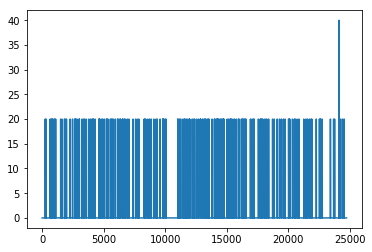

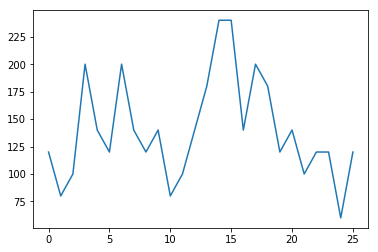

In [11]:
import matplotlib.pyplot as plt
print(np.mean(reward_lst))
plt.plot(reward_lst)
plt.show()
plt.plot(scores)

In [15]:
np.mean(scores)

140.0

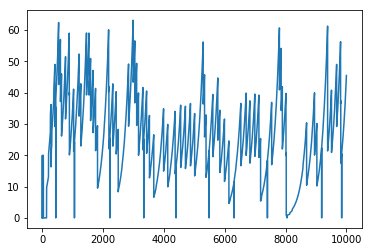

In [12]:
plt.plot(agent.r_disco)
#plt.plot(agent.d*20)

In [13]:
np.mean(reward_lst)

0.14724323449698637

In [14]:
np.mean(score)

0.0

In [ ]:
#Чтобы анализировать разрешимость задачи
def replicate_reward(sar,border=0,wanted_part=0.5):
    part = np.mean(sar[:,-1:]>border)
    if part==0:
        print('ERROR')
        return(sar)
    else:
        while part<wanted_part:
            sar=np.vstack((sar,sar[np.where(sar[:,-1:]>border)[0],:]))
            part = np.mean(sar[:,-1:]>border)
        print(part)
        return(sar)

In [ ]:
sar=make_sar_table(s_list,a_list,reward_lst)
sar=replicate_reward(sar)
X=sar[1:,:]
Y=sar[:-1,:]
Y=sar[:-1,-1:]
Y=sar[1:,-1:]
sar_width=X.shape[1]
nn = Sequential()
nn.add(Dense(200, input_dim=sar_width, activation='relu',
                kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.01)))
nn.add(BatchNormalization())
nn.add(Dropout(0.2))
nn.add(Dense(200, activation='relu',
                kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.01)))
nn.add(Dropout(0.2))
nn.add(BatchNormalization())
nn.add(Dense(200, activation='relu',
                kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.01)))
nn.add(Dropout(0.2))
nn.add(BatchNormalization())
#nn.add(Dense(sar_width, activation='linear',
#                kernel_initializer='he_uniform'))
nn.add(Dense(1, activation='linear',
                kernel_initializer='he_uniform'))

nn.summary()
nn.compile(loss='mse', optimizer=Adam(lr=0.001))
l=X.shape[0]
X_train=X[:int(l/2),:]
Y_train=Y[:int(l/2),:]
X_test=X[int(l/2):,:]
Y_test=Y[int(l/2):,:]
nn.fit(X_train, Y_train, batch_size=1200,epochs=30000, verbose=1)

In [ ]:
Y_pred=np.array(nn.predict(X_test),ndmin=2)
mse = np.mean((Y_pred-Y_test)**2)
print(mse)
rmae=np.mean(np.abs(Y_pred-Y_test))/np.mean(np.abs(Y_test))
print(rmae)
rmae_diversed=np.mean(np.abs(Y_pred-Y_test),axis=0)/np.mean(np.abs(Y_test),axis=0)
print(rmae_diversed)

In [ ]:
colnumn_num=-1
plt.plot(Y_pred[:3000,colnumn_num])
plt.plot(Y_test[:3000,colnumn_num])
plt.show()

In [ ]:
#train (переобучение?)
Y_pred=np.array(nn.predict(X_train),ndmin=2)
mse = np.mean((Y_pred-Y_train)**2)
print(mse)
rmae=np.mean(np.abs(Y_pred-Y_train))/np.mean(np.abs(Y_train))
print(rmae)
rmae_diversed=np.mean(np.abs(Y_pred-Y_train),axis=0)/np.mean(np.abs(Y_train),axis=0)
print(rmae_diversed)

colnumn_num=-1
plt.plot(Y_pred[:1300,colnumn_num])
plt.plot(Y_train[:1300,colnumn_num])
plt.show()

In [ ]:
import xgboost as xgb
xgbparams = {
    'booster':'gbtree',
    'metric':'mse',
    'objective':'reg:squarederror',
    'verbosity':0,
    'max_depth': 7,
    'n_estimators': 90,
    'eta': 0.3,
    'nthreads': 2,
    'seed':0
}
nn=xgb.XGBRegressor(**xgbparams)
nn.fit(X_train[:int(l/4),:], Y_train[:int(l/4),:],
           eval_set=[(X_train[int(l/4):,:], Y_train[int(l/4):,:])],
           verbose=True)

In [3]:
import tensorflow as tf
tf.config.list_physical_devices()

AttributeError: module 'tensorflow._api.v1.config' has no attribute 'list_physical_devices'

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15785247116786031844
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14975421868180287934
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9104988922605712513
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
tf.__version__

'1.14.0'

In [10]:
%%time
for i in range(10):
    i2v.get_vec(next_state,resize_type='resize')

CPU times: user 2.3 s, sys: 165 ms, total: 2.46 s
Wall time: 668 ms
